# Allele frequency spectrum

In [ ]:
!pip install -q malariagen_data
!pip install -q scikit-allel

### importing necessary package

In [2]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar

In [3]:
#import random
from collections import Counter
from tqdm.dask import TqdmCallback
from tqdm.auto import tqdm
import functools


In [4]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib_venn as venn
import seaborn as sns

In [5]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive/"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


Importing malariagen data set

In [6]:
ag3 = malariagen_data.Ag3()
#ag3

#samples sets
sets = ["1191-VO-MULTI-OLOUGHLIN-VMF00106", "1191-VO-MULTI-OLOUGHLIN-VMF00140",
        "AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C"]
df_samples = ag3.sample_metadata(sample_sets=sets)#.set_index("sample_id")
bf_samples = df_samples.query('country == "Burkina Faso"')
#bf_samples.groupby(['location', 'aim_species']).size()

Let's select the the sample set from

In [7]:
from collections import Counter

#Create population column
bf_samples = df_samples.query('country == "Burkina Faso"')
s1, s2, s3, y,  pop_labels, pop_colors, pop_labels_year, pop_colors_year = [], [], [],[], {}, {}, {}, {}
for iso, species in zip(bf_samples.location, bf_samples.aim_species):
    s1.append(iso[:4]+'_'+species[:3])
bf_samples.insert(4, 'population', s1)
bf_samples_sel = pd.concat([bf_samples, bf_samples])
pop_ids = list(bf_samples.population.unique())

# Pop_year
for pop, year in zip(bf_samples.population, bf_samples.year):
    y.append(pop+'_'+str(year))
bf_samples.insert(5, 'pop_year', y)
pop_year = list(bf_samples.pop_year.unique())

#pop_id
for idx, species in zip(bf_samples.location, bf_samples.aim_species):
  w = idx.split(' ')[0][:14]
  s2.append(w+' $An.'+species)
val = list(Counter(s2).keys())
for idx, vl in zip(pop_ids, val):
    pop_labels[idx]=vl
pop_labels

for idx, species, year in zip(bf_samples.location, bf_samples.aim_species, bf_samples.year):
  w = idx.split(' ')[0][:14]
  s3.append(w+' $An.'+species+' ('+f'{year}' +')')
val2 = list(Counter(s3).keys())
for idx, vl in zip(pop_year, val2):
    pop_labels_year[idx]=vl
pop_labels_year

#pop_labels
colored = sns.color_palette("husl", len(pop_ids))
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

colored2 = sns.color_palette("husl", len(pop_year))
for i in range(len(pop_year)):
    pop_colors_year[pop_year[i]] = colored2[i]

#pop_cohort
coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])

#remove some populations
pop_rm = ['Bana_ara', 'Bana_int', 'Sour_ara']
del s1, s2, s3, y, val, val2, colored, colored2

<ipython-input-7-1a8d54b5e361>:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  coh_pop = dict([(f"{p}", list(df.index)) for (p), df in bf_samples.reset_index().groupby(['population'])])


In [8]:
query_year = {'Bana_ara_2014': "location == ['Bana Market', 'Bana Village'] and aim_species == 'arabiensis' and year==2014",
              'Bana_col_2012': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii' and year==2012",
              'Bana_col_2014': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii' and year==2014",
              'Bana_col_2015': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii' and year==2015",
              'Bana_col_2016': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii' and year==2016",
              'Bana_col_2017': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii' and year==2012",
              'Bana_gam_2012': "location == ['Bana Market', 'Bana Village'] and aim_species == 'gambiae' and year==2012",
              'Bana_gam_2014': "location == ['Bana Market', 'Bana Village'] and aim_species == 'gambiae' and year==2014",
              'Bana_gam_2015': "location == ['Bana Market', 'Bana Village'] and aim_species == 'gambiae' and year==2015",
              'Bana_gam_2016': "location == ['Bana Market', 'Bana Village'] and aim_species == 'gambiae' and year==2016",
              'Bana_int_2012': "location == ['Bana Market', 'Bana Village'] and aim_species == 'intermediate_gambiae_coluzzii' and year==2012",
              'Mono_gam_2004': "location == 'Monomtenga' and aim_species == 'gambiae' and year==2004",
              'Pala_ara_2014': "location == 'Pala' and aim_species == 'arabiensis' and year==2014",
              'Pala_ara_2015': "location == 'Pala' and aim_species == 'arabiensis' and year==2015",
              'Pala_ara_2016': "location == 'Pala' and aim_species == 'arabiensis' and year==2016",
              'Pala_col_2012': "location == 'Pala' and aim_species == 'coluzzii' and year==2012",
              'Pala_gam_2012': "location == 'Pala' and aim_species == 'gambiae' and year==2012",
              'Pala_gam_2014': "location == 'Pala' and aim_species == 'gambiae' and year==2014",
              'Pala_gam_2015': "location == 'Pala' and aim_species == 'gambiae' and year==2015",
              'Pala_gam_2016': "location == 'Pala' and aim_species == 'gambiae' and year==2016",
              'Pala_gam_2017': "location == 'Pala' and aim_species == 'gambiae' and year==2017",
              'Pala_int_2017': "location == 'Pala' and aim_species == 'intermediate_gambiae_coluzzii' and year==2017",
              'Sour_ara_2017': "location == 'Souroukoudinga' and aim_species == 'arabiensis' and year==2017",
              'Sour_col_2012': "location == 'Souroukoudinga' and aim_species == 'coluzzii' and year==2012",
              'Sour_col_2014': "location == 'Souroukoudinga' and aim_species == 'coluzzii' and year==2014",
              'Sour_col_2015': "location == 'Souroukoudinga' and aim_species == 'coluzzii' and year==2015",
              'Sour_col_2016': "location == 'Souroukoudinga' and aim_species == 'coluzzii' and year==2016",
              'Sour_col_2017': "location == 'Souroukoudinga' and aim_species == 'coluzzii' and year==2017",
              'Sour_gam_2012': "location == 'Souroukoudinga' and aim_species == 'gambiae' and year==2012",
              'Sour_gam_2014': "location == 'Souroukoudinga' and aim_species == 'gambiae' and year==2014",
              'Sour_gam_2015': "location == 'Souroukoudinga' and aim_species == 'gambiae' and year==2015",
              'Sour_gam_2016': "location == 'Souroukoudinga' and aim_species == 'gambiae' and year==2016"}

query_sp = {'Bana_ara': "location == ['Bana Market', 'Bana Village'] and aim_species == 'arabiensis'",
            'Bana_col': "location == ['Bana Market', 'Bana Village'] and aim_species == 'coluzzii'",
            'Bana_gam': "location == ['Bana Market', 'Bana Village'] and aim_species == 'gambiae'",
            'Bana_int': "location == ['Bana Market', 'Bana Village'] and aim_species == 'intermediate_gambiae_coluzzii'",
            'Mono_gam': "location == 'Monomtenga' and aim_species == 'gambiae'",
            'Pala_ara': "location == 'Pala' and aim_species == 'arabiensis'",
            'Pala_col': "location == 'Pala' and aim_species == 'coluzzii'",
            'Pala_gam': "location == 'Pala' and aim_species == 'gambiae'",
            'Pala_int': "location == 'Pala' and aim_species == 'intermediate_gambiae_coluzzii'",
            'Sour_ara': "location == 'Souroukoudinga' and aim_species == 'arabiensis'",
            'Sour_col': "location == 'Souroukoudinga' and aim_species == 'coluzzii'",
            'Sour_gam': "location == 'Souroukoudinga' and aim_species == 'gambiae'"
            }

pops1 = ['Bana_col_2012','Bana_col_2014','Bana_col_2015','Bana_col_2016','Bana_col_2017',
       'Bana_gam_2012','Bana_gam_2014','Bana_gam_2015','Bana_gam_2016','Mono_gam_2004',
       'Pala_ara_2014','Pala_ara_2015','Pala_ara_2016','Pala_col_2012','Pala_gam_2012',
       'Pala_gam_2014','Pala_gam_2015','Pala_gam_2016','Pala_gam_2017','Sour_col_2012',
       'Sour_col_2014','Sour_col_2015','Sour_col_2016','Sour_col_2017','Sour_gam_2012',
       'Sour_gam_2014','Sour_gam_2015','Sour_gam_2016']

pops = ['Bana_col', 'Bana_gam', 'Mono_gam', 'Pala_ara', 'Pala_col', 'Pala_gam', 'Sour_col', 'Sour_gam']

In [9]:
@functools.lru_cache(maxsize=None)
def compute_sfs(contig, sample_query):
  # access genotypes
  ds_geno = ag3.snp_calls(region=contig, sample_query=sample_query, sample_sets=sets)
  #count alleles and load into memory
  pos = ds_geno["variant_position"].values
  filt = 'gamb_colu_arab'
  filt_val = ds_geno[f"variant_filter_pass_{filt}"].values
  gt_filtered = allel.GenotypeDaskArray(ds_geno["call_genotype"][filt_val].data)

  # count alleles and load into memory
  with TqdmCallback(desc="Count max alleles"):
    ac = gt_filtered.count_alleles(max_allele=3).compute()
  # compute sfs
  loca = (ac.max_allele() <= 1) & (ac.is_segregating())
  aca = ac[loca][:, :2]
  n = np.max(ac.sum(axis=1))
  s = allel.sfs_folded_scaled(aca)
  return pos, s, n

def compute_accessible_length(region='3L', site_mask='gamb_colu_arab'):
  access = ag3.is_accessible(region=region, site_mask='gamb_colu_arab')
  l = np.count_nonzero(access)
  return l

In [10]:
## compute sfs by pop - village - year
#sf1, nf1 = {}, {}
#for key in pops1:
#  _, sf1[key], nf1[key] = compute_sfs(contig='3L', sample_query=f'{query_year[key]}')

In [11]:
## compute sfs by pop - village
#sf2, nf2 = {}, {}
#for key in pops:
#  _, sf2[key], nf2[key] = compute_sfs(contig='2L', sample_query=f'{query_sp[key]}')

In [12]:
## Save data sfs
#np.save('drive/MyDrive/Genomic/diversity_stats/3L_sf1.npy', sf1)
#np.save('drive/MyDrive/Genomic/diversity_stats/3L_nf1.npy', nf1)

#np.save('drive/MyDrive/Genomic/diversity_stats/3L_sf2.npy', sf2)
#np.save('drive/MyDrive/Genomic/diversity_stats/3L_nf2.npy', nf2)

In [13]:
## load sfs data
sf1 = np.load('drive/MyDrive/Genomic/diversity_stats/3L_sf1.npy', allow_pickle='TRUE').item()
nf1 = np.load('drive/MyDrive/Genomic/diversity_stats/3L_nf1.npy', allow_pickle='TRUE').item()

In [19]:
pop_id = ['Bana_gam_2016']
def plot_sfs_year(sf, nf, legend=False, ax=None, lw=2, fn=None, ylab=False, xlab=False):
    l = compute_accessible_length(region='3L', site_mask='gamb_colu_arab')
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,12))
    # set order for Z
    for pop in pop_id:
      s1 = sf[pop] / l
      n1 = nf[pop]
      allel.plot_sfs_folded_scaled(s=s1, n=n1, label=pop, ax=ax,
                                   plot_kwargs=dict(color=pop_colors_year[pop],lw=lw, alpha=0.8))

    if ylab == True:
        ax.set_ylabel('variant density (bp$^{-1}$)', fontsize=12)
    else:
        ax.set_ylabel('')

    if xlab == True:
        ax.set_xlabel('minor allele frequency', fontsize=12)
    else:
        ax.set_xlabel('')
    ax.set_ylim(0, 0.06)
    ax.set_xlim(0, 0.5)
#     if legend:
#         ax.legend()


    handles = [mpl.patches.Patch(color=pop_colors_year[pop], label=pop_labels_year[pop]) for pop in pop_id]
    ax.legend(handles=handles, loc='upper left', ncol=1, labelspacing=0.8)
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=300, bbox_inches='tight');

<ipython-input-21-5a3ae831aa14>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


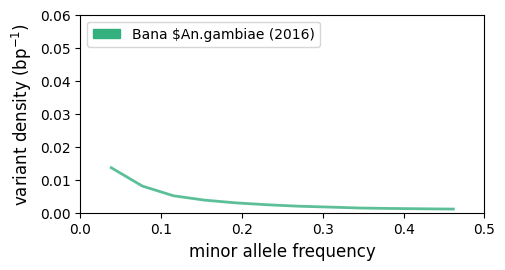

In [21]:
## An. gambiae
fig, ax = plt.subplots(figsize=(24,18))
gs = GridSpec(6, 4)

ax0 = plt.subplot(gs[0, 0])
pop_id = ['Bana_gam_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax0, lw=2, fn=None, ylab=True, xlab=True)


<ipython-input-24-15730529edb0>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


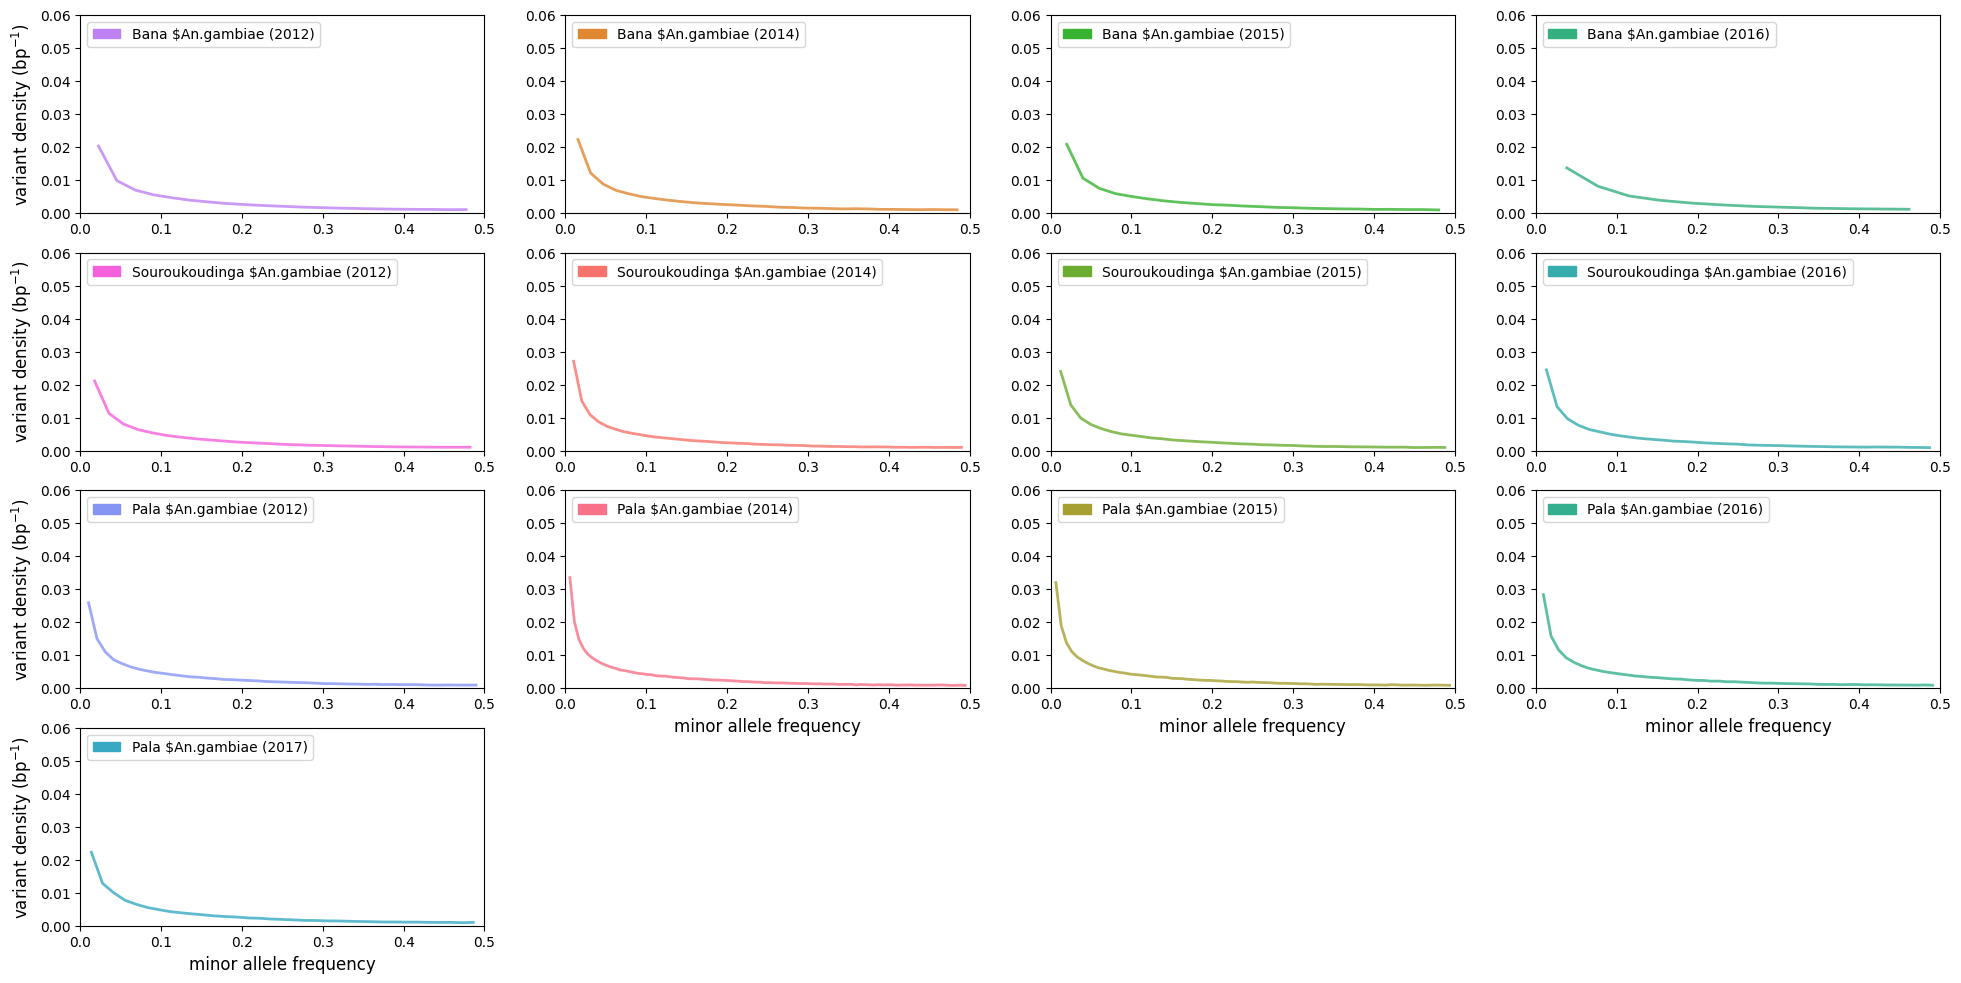

In [24]:
## An. gambiae
fig, ax = plt.subplots(figsize=(24,18))
gs = GridSpec(6, 4)

ax0 = plt.subplot(gs[0, 0])
pop_id = ['Bana_gam_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax0, lw=2, fn=None, ylab=True, xlab=False)

ax1 = plt.subplot(gs[0, 1])
pop_id = ['Bana_gam_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax1, lw=2, fn=None, ylab=False, xlab=False)

ax2 = plt.subplot(gs[0, 2])
pop_id = ['Bana_gam_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax2, lw=2, fn=None, ylab=False, xlab=False)

ax3 = plt.subplot(gs[0, 3])
pop_id = ['Bana_gam_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax3, lw=2, fn=None, ylab=False, xlab=False)

ax4 = plt.subplot(gs[1, 0])
pop_id = ['Sour_gam_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax4, lw=2, fn=None, ylab=True, xlab=False)

ax5 = plt.subplot(gs[1, 1])
pop_id = ['Sour_gam_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax5, lw=2, fn=None, ylab=False, xlab=False)

ax6 = plt.subplot(gs[1, 2])
pop_id = ['Sour_gam_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax6, lw=2, fn=None, ylab=False, xlab=False)

ax7 = plt.subplot(gs[1, 3])
pop_id = ['Sour_gam_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax7, lw=2, fn=None, ylab=False, xlab=False)

ax8 = plt.subplot(gs[2, 0])
pop_id = ['Pala_gam_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax8, lw=2, fn=None, ylab=True, xlab=False)

ax9 = plt.subplot(gs[2, 1])
pop_id = ['Pala_gam_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax9, lw=2, fn=None, ylab=False, xlab=True)

ax10 = plt.subplot(gs[2, 2])
pop_id = ['Pala_gam_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax10, lw=2, fn=None, ylab=False, xlab=True)

ax11 = plt.subplot(gs[2, 3])
pop_id = ['Pala_gam_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax11, lw=2, fn=None, ylab=False, xlab=True)

ax12 = plt.subplot(gs[3, 0])
pop_id = ['Pala_gam_2017']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax12, lw=2, fn=None, ylab=True, xlab=True)

#ax13 = plt.subplot(gs[3, 1])
#pop_id = ['Mono_gam_2004']
#plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax13, lw=2, fn=None, ylab=False, xlab=True)

#ax14 = plt.subplot(gs[3, 2])
#pop_id = [' ']
#plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax2, lw=2, fn=None, ylab=False, xlab=False)

#ax15 = plt.subplot(gs[3, 3])
#pop_id = [' ']
#plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax3, lw=2, fn=None, ylab=False, xlab=False)

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/diversity_stats/ag_3L_sf1.png", dpi=600, bbox_inches='tight')

<ipython-input-23-afb46a23c4ae>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


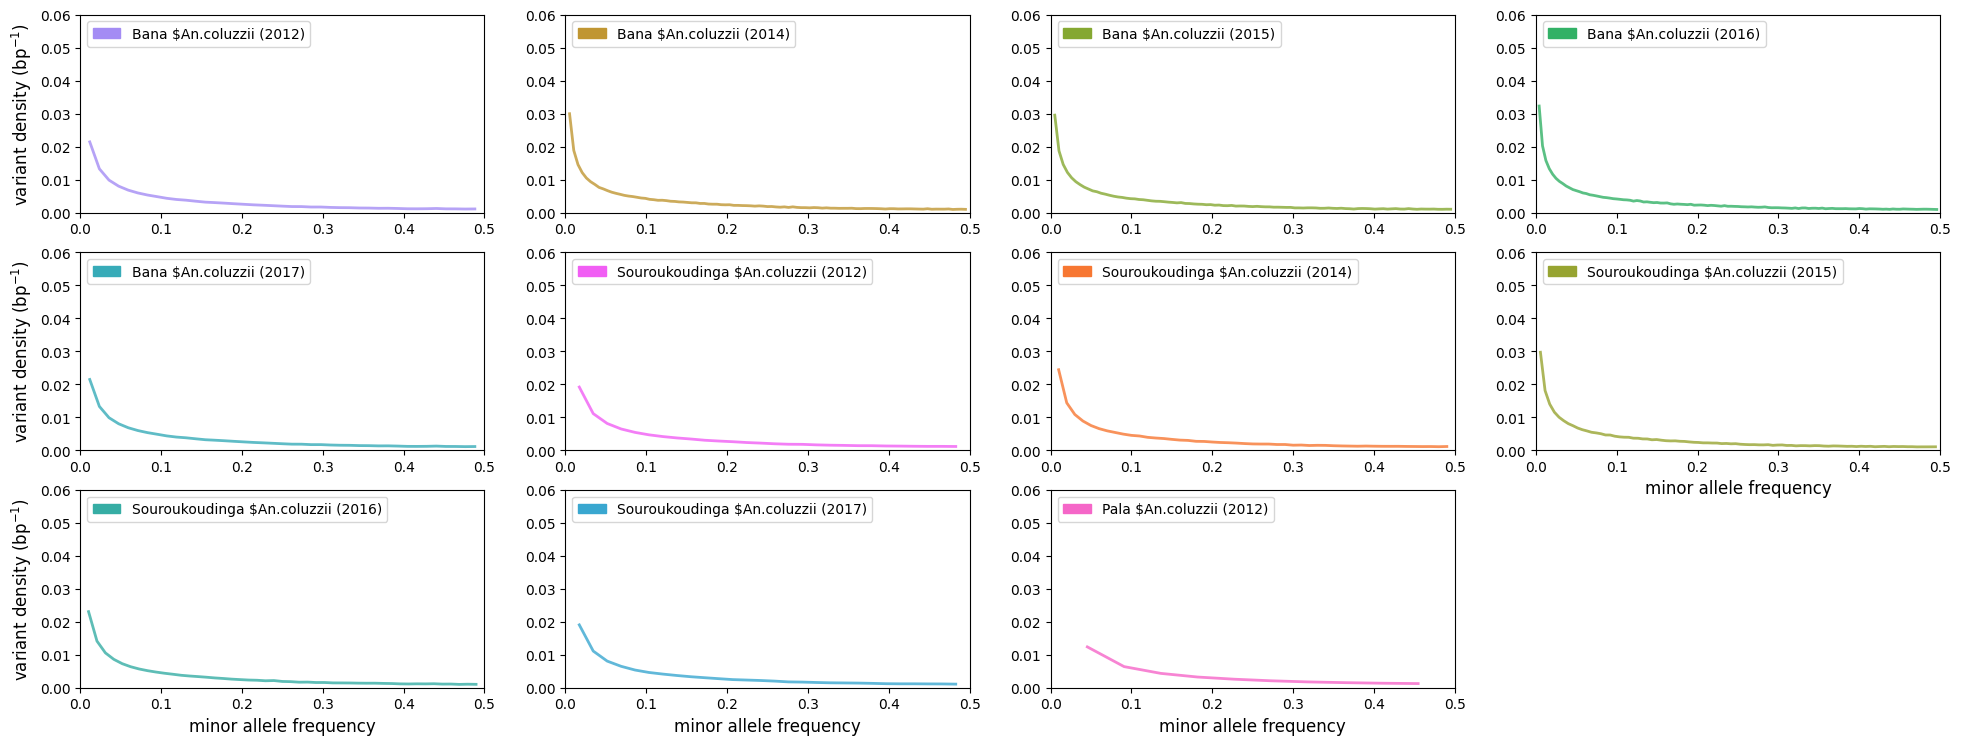

In [23]:
## An. coluzzii
fig, ax = plt.subplots(figsize=(24,18))
gs = GridSpec(6, 4)

ax0 = plt.subplot(gs[0, 0])
pop_id = ['Bana_col_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax0, lw=2, fn=None, ylab=True, xlab=False)

ax1 = plt.subplot(gs[0, 1])
pop_id = ['Bana_col_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax1, lw=2, fn=None, ylab=False, xlab=False)

ax2 = plt.subplot(gs[0, 2])
pop_id = ['Bana_col_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax2, lw=2, fn=None, ylab=False, xlab=False)

ax3 = plt.subplot(gs[0, 3])
pop_id = ['Bana_col_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax3, lw=2, fn=None, ylab=False, xlab=False)

ax4 = plt.subplot(gs[1, 0])
pop_id = ['Bana_col_2017']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax4, lw=2, fn=None, ylab=True, xlab=False)

ax5 = plt.subplot(gs[1, 1])
pop_id = ['Sour_col_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax5, lw=2, fn=None, ylab=False, xlab=False)

ax6 = plt.subplot(gs[1, 2])
pop_id = ['Sour_col_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax6, lw=2, fn=None, ylab=False, xlab=False)

ax7 = plt.subplot(gs[1, 3])
pop_id = ['Sour_col_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax7, lw=2, fn=None, ylab=False, xlab=True)

ax8 = plt.subplot(gs[2, 0])
pop_id = ['Sour_col_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax8, lw=2, fn=None, ylab=True, xlab=True)

ax9 = plt.subplot(gs[2, 1])
pop_id = ['Sour_col_2017']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax9, lw=2, fn=None, ylab=False, xlab=True)

ax10 = plt.subplot(gs[2, 2])
pop_id = ['Pala_col_2012']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax10, lw=2, fn=None, ylab=False, xlab=True)

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/diversity_stats/ac_3L_sf1.png", dpi=600, bbox_inches='tight')

<ipython-input-25-40dcc47ae86a>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[0, 0])


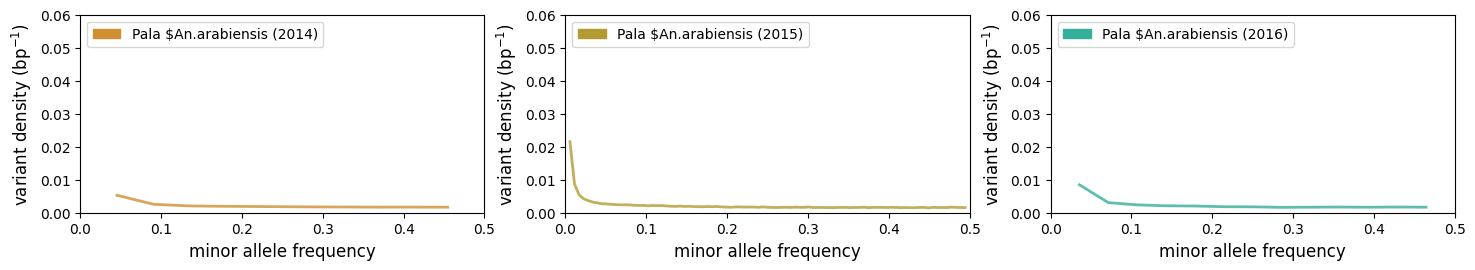

In [25]:
## An. arabiensis
fig, ax = plt.subplots(figsize=(24,18))
gs = GridSpec(6, 4)

ax0 = plt.subplot(gs[0, 0])
pop_id = ['Pala_ara_2014']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax0, lw=2, fn=None, ylab=True, xlab=True)

ax1 = plt.subplot(gs[0, 1])
pop_id = ['Pala_ara_2015']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax1, lw=2, fn=None, ylab=True, xlab=True)

ax2 = plt.subplot(gs[0, 2])
pop_id = ['Pala_ara_2016']
plot_sfs_year(sf=sf1, nf=nf1, legend=False, ax=ax2, lw=2, fn=None, ylab=True, xlab=True)

# Save fig
fig.savefig(f"drive/MyDrive/Genomic/diversity_stats/aa_3L_sf1.png", dpi=600, bbox_inches='tight')